# Defining the scope of our simulation

## Context
In decentralized cloud computing environments, ensuring fair and efficient interactions can be challenging due to limited visibility into the individual behavior of actors involved in tasks. Traditional mechanisms struggle to manage task failures effectively because it's often unclear which actor is responsible for the failure. As a result, there is no clear way to incentivize good behavior and reliability.

To address this problem, we introduce a "Reputation System," which rewards or penalizes actors based on their behavior. Rather than punishing all parties involved in a failure, this system adjusts each actor's reputation according to their contribution to successes or failures. Actors with better reputations are more likely to succeed, while those with poor reputations face increased difficulty and eventual exclusion from the system. The goal is to create incentives for cooperative behavior and reliability by naturally filtering out faulty actors over time.

## Core elements of the Simulation:  
A list of n actors, with each actor having:
* An initial reputation score R0

A list of faulty sets of actors, with each set having:
* Between 1 and n actors.
* A probability of failure.

## Task process

```
@startuml
title Task Execution Flow

start

:Pick a random set of 2 to n actors;

:Find all subsets of the chosen actors that exist in the faulty sets;

while (Faulty subsets remain?) is (Yes)
  :Check if the subset is triggering failure this execution\n(Draw x, a random number between 0 and 1 and\n compare it to the subset failure probability P_fail);
  
  if (N < P_fail?) then (Yes)
    :Task is a failure;
    :Reduce the reputation of actors in the faulty subsets;
    stop
  else (No)
    :Continue checking remaining subsets;
  endif
endwhile

:Task is a success;
:Increase the reputation of all actors in the set;

stop
@enduml
```

## Simulation process

1. We execute N number of tasks.
2. Actors are ignored by other actors when their reputation drops below a threshold.
3. New actors are regularly added, and they are also included in the faulty set list. For each, a random P_fail is assigned using a normal distribution of fault probabilities.
4. For each new actor, a random number of faulty combinations are generated and added to the faulty set with corresponding P_fail values determined by a normal distribution of fault probabilities.

## Result to observe
* The average number of successful and failed tasks and their ratio.
* The evolution of the number of actors in the system and the average failure rate per actor.
* The global evolution of the system's failure rate (average task failure rate).

## Code
### Importing libraries

In [223]:
import random
import numpy as np
from scipy.stats import pareto
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import Pool
from collections import deque

### Defining constants

In [224]:
N_ACTORS_INITIAL = 100  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
N_SIMILAR_ACTORS = 10  # Number of similar actors for each actor
R0 = 1000  # Initial reputation of each actor
N_TASKS = 80000  # Number of tasks to simulate
SLASH_AMOUNT = 200  # Amount slashed for failed tasks
REWARD_AMOUNT = 50  # Reward for successful tasks
NEW_ACTOR_INTERVAL = 10000000000000  # Frequency of new actor addition (in tasks)
NEW_ACTOR_FAULTY_COMBOS = 0  # Number of faulty combinations per new actor
MONTE_CARLO_RUNS = 50  # Number of Monte Carlo simulations
BIN_SIZE = 0.05  # You can adjust this value as needed
MIN_REPUTATION = 1  # Minimum cap for reputation
MAX_REPUTATION = 1000  # Maximum cap for reputation
RECENT_TASK_WINDOW = 20 # Number of recent tasks to consider for reputation calculation (sliding windows mode)
# window size of 468 work, but 467 doesn't, why is that ?

# Display
X_MAX = 0.50
Y_MAX = (N_ACTORS_INITIAL + N_TASKS//NEW_ACTOR_INTERVAL) // 5

### Testing different failure rate distribution

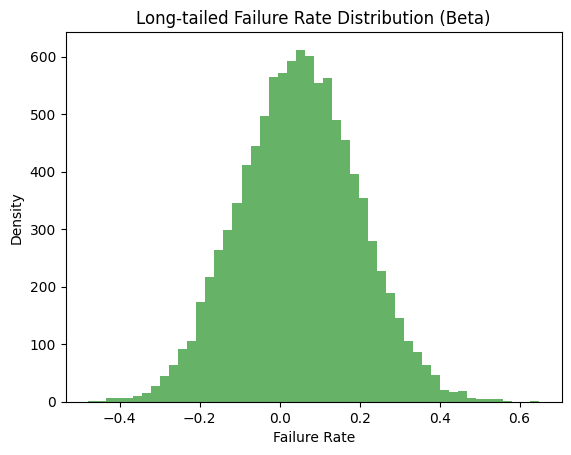

In [225]:
# Testing normal distribution ------------------------------------------
# Using a normal distribution with mean 0.18 (average failure rate) and a small std dev of 0.05
mu, sigma = 0.05, 0.15
p_fail_distribution = np.random.normal(mu, sigma, 10000)


# Testing log normal distribution --------------------------------------
# p_fail_distribution = np.random.lognormal(-1, 2, 10000)

# Testing exponential distribution -------------------------------------
# Using an exponential distribution with lambda parameter (rate of failure occurrence)
lambda_exponential = 1.0 / 6.0  # Mean time between failures (inverse of average failure rate)
# p_fail_distribution = np.random.exponential(lambda_exponential, 10000)

# Testing poisson distribution -----------------------------------------
# Using a Poisson distribution with lambda parameter (average rate of occurrence of failures)
# Poisson distribution is a discrete distribution, so we can't use it directly for failure rates
# lambda_poisson = 0.18  # Average actor failure rate
# p_fail_distribution = np.random.poisson(lambda_poisson, 10000)

# Testing pareto distribution ------------------------------------------
# Using a Pareto distribution with shape parameter `b=2` (the smaller the shape, the heavier the tail)
b = 0.5
scale = 0.001  # Set scale to reflect the typical range of values around the failure rate
# p_fail_distribution = pareto.rvs(b, scale=scale, size=10000)

# Testing continuous distribution ----------------------------------
# p_fail_distribution = [i/10000.0 for i in range(5000)]
# It seems that for a continuous distribution going from 0 to 0.3605 is the tipping point to ruining everyone
# This correspond to an average actor failure rate of 0.18025
# We notice that almost all actors are being evicted from the system at around task 600, until there is only 4 actors left. 
# It seems that if one of those actors is faulty, the system never recovers, but if we reach that point with only reliable actors, 
# then the system progressively recovers and then grows up to new highs.

# Testing binary distribution (0 or 1) ------------------------------
# p_fail_distribution = [0 for _ in range(1000)] + [1 for _ in range(1000)]
# We try to get the same average failure rate as the continuous distribution, but with a binary distribution
# Not the same behaviour, tt seem that the average actor failure rate is not the most important factor ?

# Plotting test distribution
plt.hist(p_fail_distribution, bins=50, density=False, alpha=0.6, color='g')
plt.title("Long-tailed Failure Rate Distribution (Beta)")
plt.xlabel("Failure Rate")
plt.ylabel("Density")
plt.show()

### Executing one simulation

In [226]:
# Initialize actors and faulty sets
class Actor:
    def __init__(self, id, reputation):
        self.id = id
        self.reputation = reputation
        self.failure_rate = 0
        self.loss = 0
        self.reward = 0
        self.nb_tasks = 0

class FaultySet:
    def __init__(self, actors, p_fail):
        self.actors = actors
        self.p_fail = p_fail

# Add an actor with a faulty set
def add_actor(actors, faulty_sets):
    # Add a new actor
    new_actor = Actor(len(actors), R0)
    actors.append(new_actor)

    # Generate a faulty set for the new actor
    faulty_set = FaultySet([new_actor], generate_p_fail())
    faulty_sets.append(faulty_set)
    new_actor.failure_rate = faulty_set.p_fail
    
    # Generate faulty combinations sets for the new actor
    generate_faulty_combinations(new_actor, actors, faulty_sets)

# Generate initial faulty sets
def generate_faulty_combinations(actor, actors, faulty_sets):
    for _ in range(NEW_ACTOR_FAULTY_COMBOS):
        subset_size = random.randint(2, N_ACTORS_TASK-1)
        subset = random.sample(actors, subset_size)
        subset.append(actor)
        p_fail = generate_p_fail()
        faulty_sets.append(FaultySet(subset, p_fail))

# Generate p_fail based on long tail distribution
def generate_p_fail():
    p_fail = np.random.choice(p_fail_distribution)
    while p_fail < 0 or p_fail > 1:
        p_fail = np.random.choice(p_fail_distribution)
    # return max(0, min(1, np.random.choice(p_fail_distribution)))
    return p_fail

def pick_task_actors(actors, num_actors):
    chosen_actors = []
    for _ in range(num_actors):
        possible_actors = random.sample(actors, N_SIMILAR_ACTORS)
        # Pick the actor with the highest reputation
        chosen_actor = max(possible_actors, key=lambda actor: actor.reputation)
        chosen_actors.append(chosen_actor)
    return chosen_actors

# Initialize actors and faulty sets
actors = [Actor(i, R0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = 0
if REWARD_AMOUNT + SLASH_AMOUNT > 0:
    failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = pick_task_actors(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                actor.nb_tasks += 1
                for actor in task_actors:
                    actor.reputation -= SLASH_AMOUNT
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        actor.nb_tasks += 1
        for actor in task_actors:
            actor.reputation += REWARD_AMOUNT

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

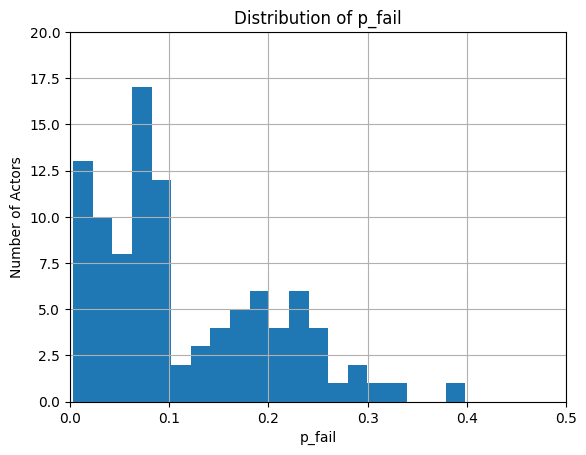

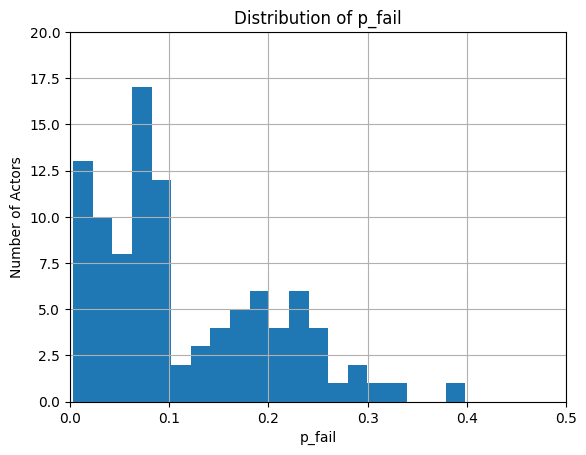

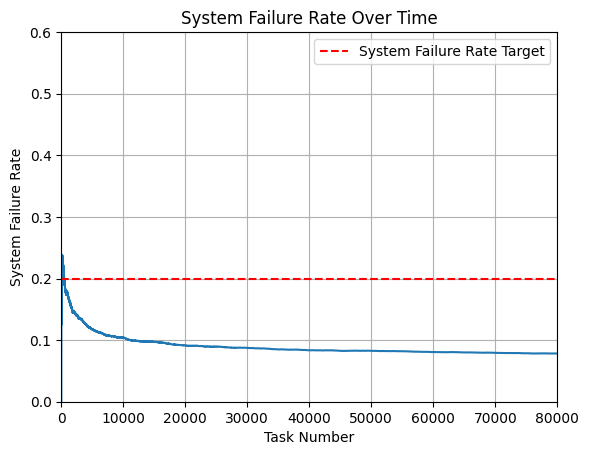

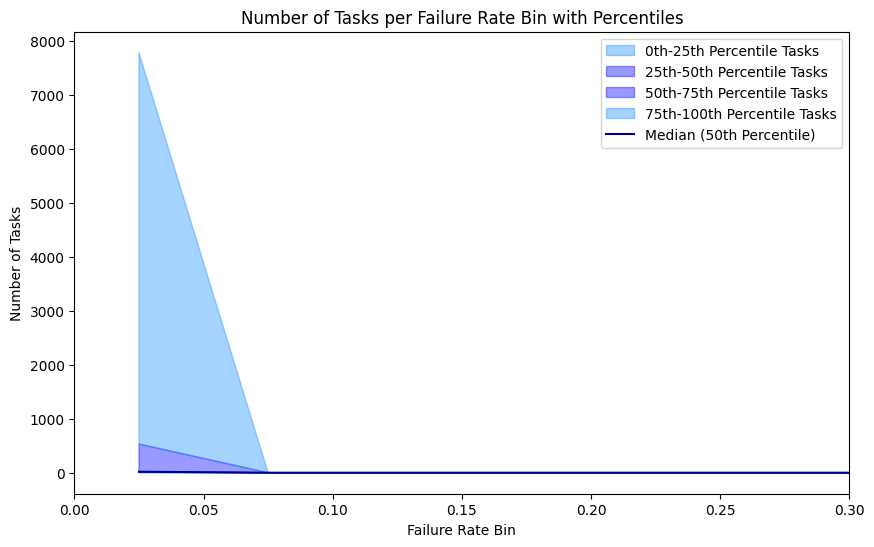

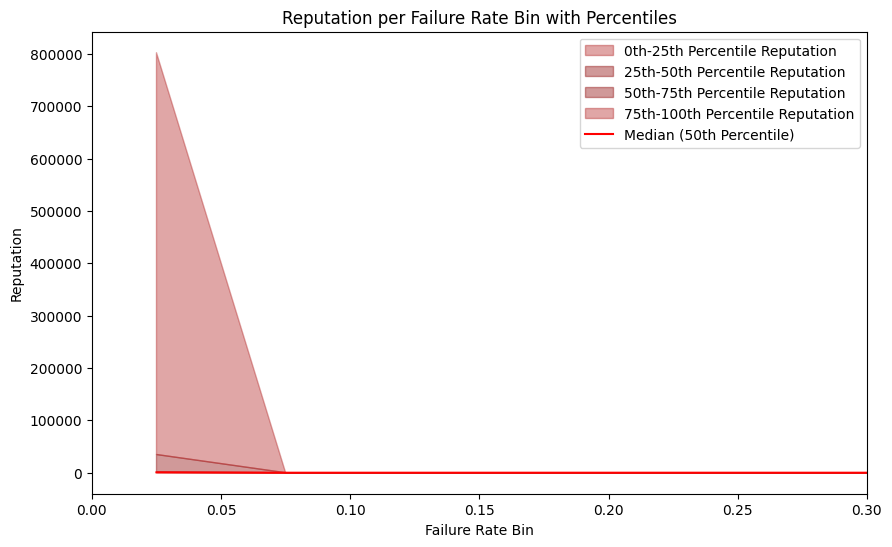

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 73734
Total failed tasks: 6266
Total number of actors: 100
Final number of actors: 100


In [227]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()
plt.show()

# NUMBER OF TASKS PER FAILURE RATE BIN
# Create the bins based on BIN_SIZE
failure_bins = np.arange(0, 1, BIN_SIZE)  # Create bins from 0 to 1 with step of BIN_SIZE

# Initialize a dictionary to store tasks per bin
tasks_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group tasks by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        tasks_per_bin[bin_index].append(actor.nb_tasks)

# Prepare percentile data for plotting
bin_centers = [failure_bins[i] + BIN_SIZE / 2 for i in range(len(failure_bins) - 1)]
tasks_percentiles = [np.percentile(tasks_per_bin[i], [0, 25, 50, 75, 100]) if tasks_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
tasks_0th = np.array([x[0] for x in tasks_percentiles])
tasks_25th = np.array([x[1] for x in tasks_percentiles])
tasks_50th = np.array([x[2] for x in tasks_percentiles])
tasks_75th = np.array([x[3] for x in tasks_percentiles])
tasks_100th = np.array([x[4] for x in tasks_percentiles])

# Plot the number of tasks with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, tasks_0th, tasks_25th, color='dodgerblue', alpha=0.4, label='0th-25th Percentile Tasks')
plt.fill_between(bin_centers, tasks_25th, tasks_50th, color='blue', alpha=0.4, label='25th-50th Percentile Tasks')
plt.fill_between(bin_centers, tasks_50th, tasks_75th, color='blue', alpha=0.4, label='50th-75th Percentile Tasks')
plt.fill_between(bin_centers, tasks_75th, tasks_100th, color='dodgerblue', alpha=0.4, label='75th-100th Percentile Tasks')
plt.plot(bin_centers, tasks_50th, color='darkblue', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# REPUTATION PER FAILURE RATE BIN
# Initialize a dictionary to store reputations per bin
reputation_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group reputations by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        reputation_per_bin[bin_index].append(actor.reputation)

# Prepare percentile data for plotting
reputation_percentiles = [np.percentile(reputation_per_bin[i], [0, 25, 50, 75, 100]) if reputation_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
reputation_0th = np.array([x[0] for x in reputation_percentiles])
reputation_25th = np.array([x[1] for x in reputation_percentiles])
reputation_50th = np.array([x[2] for x in reputation_percentiles])
reputation_75th = np.array([x[3] for x in reputation_percentiles])
reputation_100th = np.array([x[4] for x in reputation_percentiles])

# Plot reputation with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, reputation_0th, reputation_25th, color='firebrick', alpha=0.4, label='0th-25th Percentile Reputation')
plt.fill_between(bin_centers, reputation_25th, reputation_50th, color='darkred', alpha=0.4, label='25th-50th Percentile Reputation')
plt.fill_between(bin_centers, reputation_50th, reputation_75th, color='darkred', alpha=0.4, label='50th-75th Percentile Reputation')
plt.fill_between(bin_centers, reputation_75th, reputation_100th, color='firebrick', alpha=0.4, label='75th-100th Percentile Reputation')
plt.plot(bin_centers, reputation_50th, color='red', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Reputation')
plt.title('Reputation per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

### Picking actors more often depending on their reputation

In [228]:
def pick_task_actors(actors, num_actors):
    chosen_actors = []
    for _ in range(num_actors):
        chosen_actor = None
        weights = [actor.reputation for actor in actors]

        while chosen_actor in chosen_actors or chosen_actor is None:
            chosen_actor = random.choices(actors, weights=weights, k=1)[0]

        chosen_actors.append(chosen_actor)
    return chosen_actors


# Initialize actors and faulty sets
actors = [Actor(i, R0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = 0
if REWARD_AMOUNT + SLASH_AMOUNT > 0:
    failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = pick_task_actors(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.reputation -= SLASH_AMOUNT
                    actor.nb_tasks += 1
                    # Cap the reputation to min
                    actor.reputation = max(actor.reputation, MIN_REPUTATION)
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        actor.nb_tasks += 1
        for actor in task_actors:
            actor.reputation += REWARD_AMOUNT

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

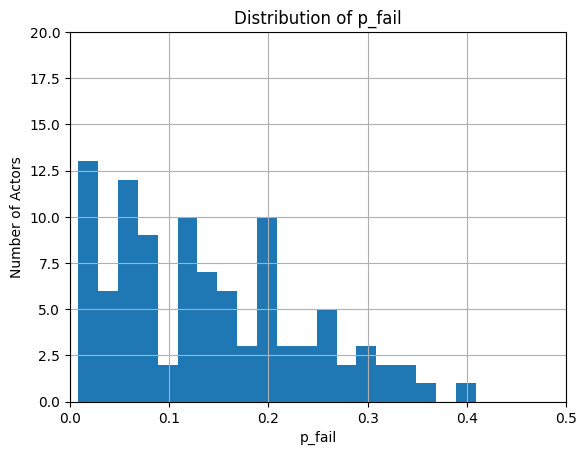

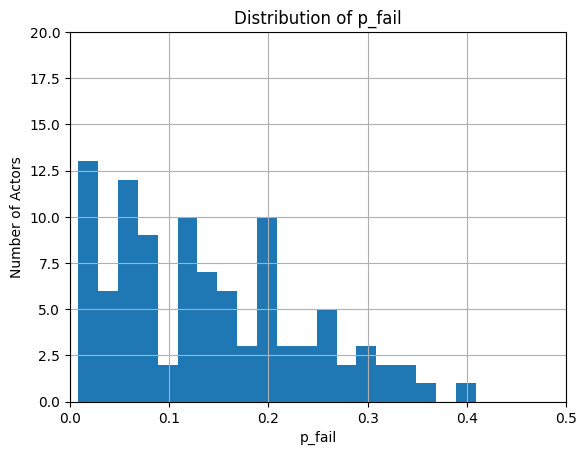

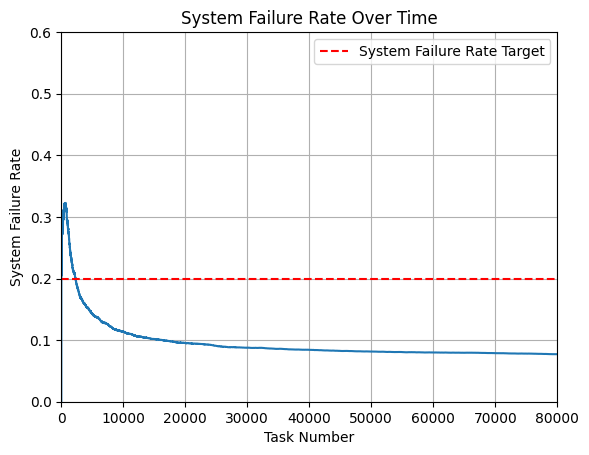

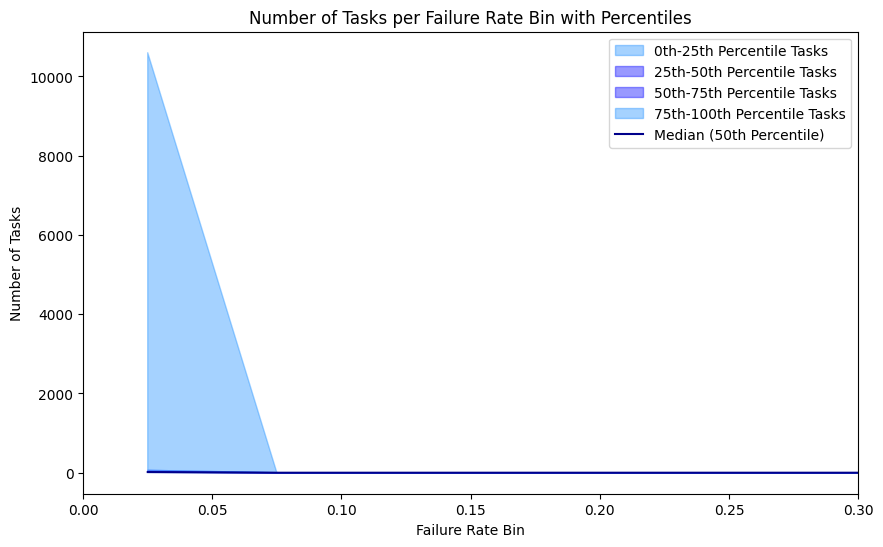

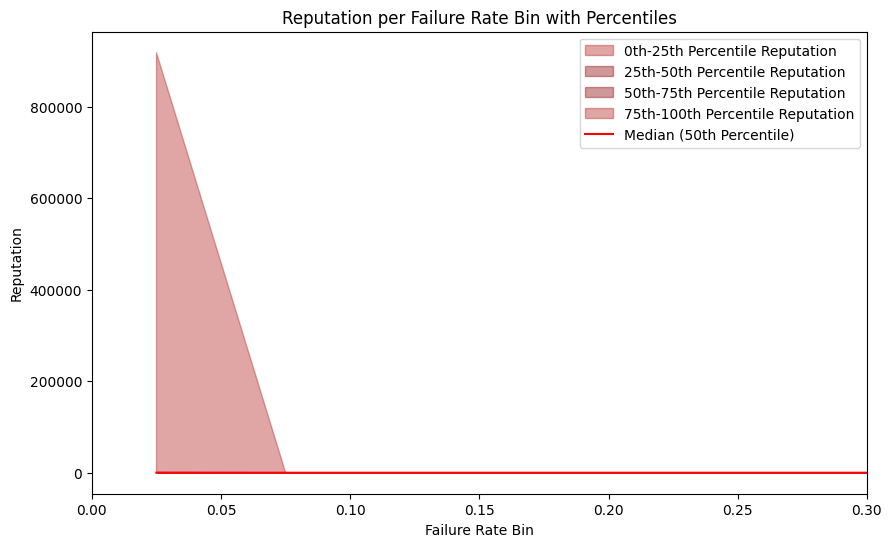

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 73826
Total failed tasks: 6174
Total number of actors: 100
Final number of actors: 100


In [229]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot system failure rate over time
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()
plt.show()

# NUMBER OF TASKS PER FAILURE RATE BIN
# Create the bins based on BIN_SIZE
failure_bins = np.arange(0, 1, BIN_SIZE)  # Create bins from 0 to 1 with step of BIN_SIZE

# Initialize a dictionary to store tasks per bin
tasks_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group tasks by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        tasks_per_bin[bin_index].append(actor.nb_tasks)

# Prepare percentile data for plotting
bin_centers = [failure_bins[i] + BIN_SIZE / 2 for i in range(len(failure_bins) - 1)]
tasks_percentiles = [np.percentile(tasks_per_bin[i], [0, 25, 50, 75, 100]) if tasks_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
tasks_0th = np.array([x[0] for x in tasks_percentiles])
tasks_25th = np.array([x[1] for x in tasks_percentiles])
tasks_50th = np.array([x[2] for x in tasks_percentiles])
tasks_75th = np.array([x[3] for x in tasks_percentiles])
tasks_100th = np.array([x[4] for x in tasks_percentiles])

# Plot the number of tasks with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, tasks_0th, tasks_25th, color='dodgerblue', alpha=0.4, label='0th-25th Percentile Tasks')
plt.fill_between(bin_centers, tasks_25th, tasks_50th, color='blue', alpha=0.4, label='25th-50th Percentile Tasks')
plt.fill_between(bin_centers, tasks_50th, tasks_75th, color='blue', alpha=0.4, label='50th-75th Percentile Tasks')
plt.fill_between(bin_centers, tasks_75th, tasks_100th, color='dodgerblue', alpha=0.4, label='75th-100th Percentile Tasks')
plt.plot(bin_centers, tasks_50th, color='darkblue', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# REPUTATION PER FAILURE RATE BIN
# Initialize a dictionary to store reputations per bin
reputation_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group reputations by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        reputation_per_bin[bin_index].append(actor.reputation)

# Prepare percentile data for plotting
reputation_percentiles = [np.percentile(reputation_per_bin[i], [0, 25, 50, 75, 100]) if reputation_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
reputation_0th = np.array([x[0] for x in reputation_percentiles])
reputation_25th = np.array([x[1] for x in reputation_percentiles])
reputation_50th = np.array([x[2] for x in reputation_percentiles])
reputation_75th = np.array([x[3] for x in reputation_percentiles])
reputation_100th = np.array([x[4] for x in reputation_percentiles])

# Plot reputation with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, reputation_0th, reputation_25th, color='firebrick', alpha=0.4, label='0th-25th Percentile Reputation')
plt.fill_between(bin_centers, reputation_25th, reputation_50th, color='darkred', alpha=0.4, label='25th-50th Percentile Reputation')
plt.fill_between(bin_centers, reputation_50th, reputation_75th, color='darkred', alpha=0.4, label='50th-75th Percentile Reputation')
plt.fill_between(bin_centers, reputation_75th, reputation_100th, color='firebrick', alpha=0.4, label='75th-100th Percentile Reputation')
plt.plot(bin_centers, reputation_50th, color='red', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Reputation')
plt.title('Reputation per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

We notice that depending on the severity of reputation bonus and malus, after 10000 tasks, there is a bigger or smaller discrepency in the number of tasks executed by actors depending on failure rates.
We notice that with a severe enough bonus/malus policy, the actors with the bigger failure rates are effectively more and more ignored. However we also notice a growing gap forming between a small number of actors which start to grab all tasks.
With the bonus/malus ratio we should be able to control the fact that actors above a certain failure rate cannot gain reputation thus getting less and less tasks. However we might want to stop actors from getting too high in reputation to avoid yoyo attack and market monopoly.

### Setting a minimum and maximum reputation

In [230]:
def pick_task_actors(actors, num_actors):
    chosen_actors = []
    for _ in range(num_actors):
        chosen_actor = None
        weights = [actor.reputation for actor in actors]

        while chosen_actor in chosen_actors or chosen_actor is None:
            possible_actor = random.choice(actors)
            chosen_actor = random.choices(actors, weights=weights, k=1)[0]

        chosen_actors.append(chosen_actor)
    return chosen_actors

# Initialize actors and faulty sets
actors = [Actor(i, R0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]

# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = 0
if REWARD_AMOUNT + SLASH_AMOUNT > 0:
    failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = pick_task_actors(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.reputation -= SLASH_AMOUNT
                    actor.nb_tasks += 1
                    # Cap the reputation to min and max values
                    actor.reputation = max(min(actor.reputation, MAX_REPUTATION), MIN_REPUTATION)
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.reputation += REWARD_AMOUNT
            actor.nb_tasks += 1
            # Cap the reputation to min and max values
            actor.reputation = max(min(actor.reputation, MAX_REPUTATION), MIN_REPUTATION)

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

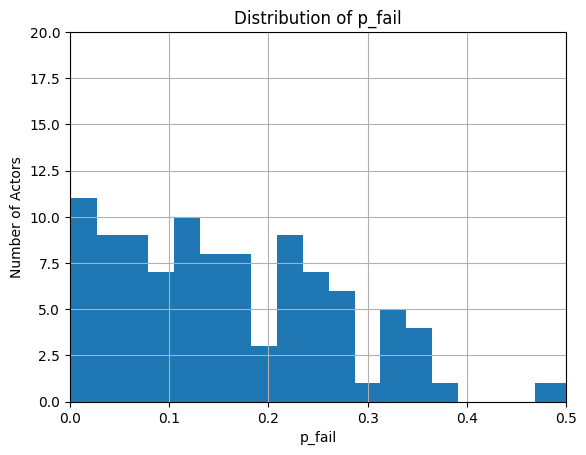

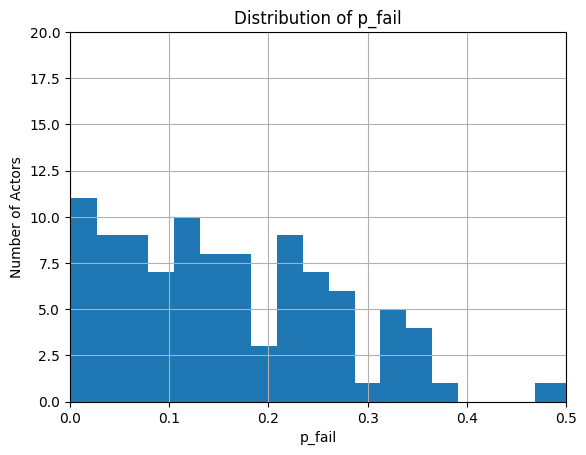

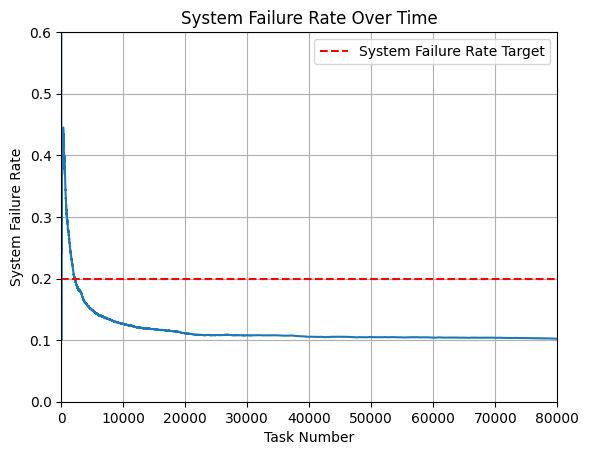

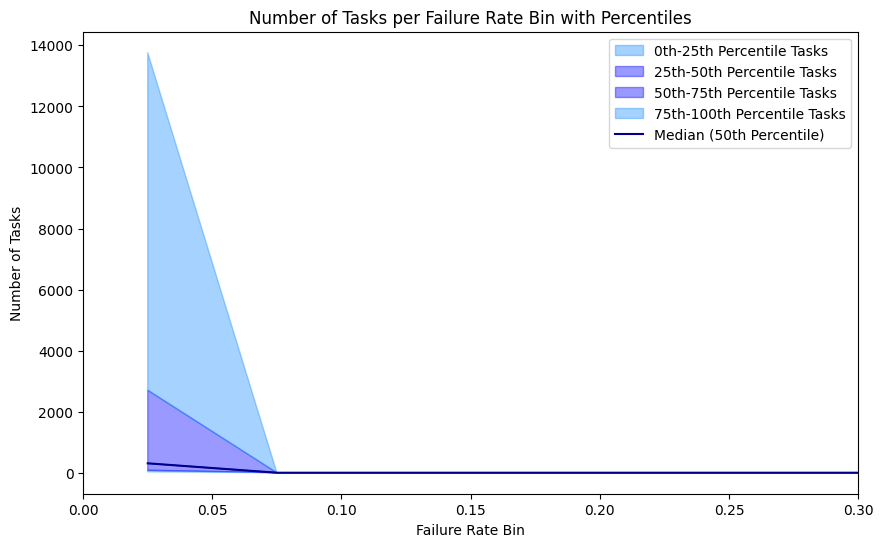

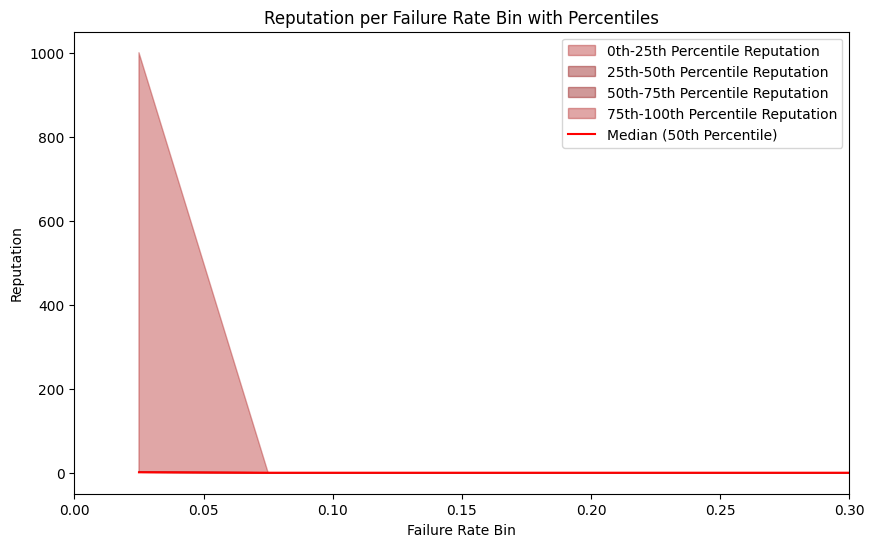

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 71811
Total failed tasks: 8189
Total number of actors: 100
Final number of actors: 100


In [231]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()
plt.show()

# NUMBER OF TASKS PER FAILURE RATE BIN
# Create the bins based on BIN_SIZE
failure_bins = np.arange(0, 1, BIN_SIZE)  # Create bins from 0 to 1 with step of BIN_SIZE

# Initialize a dictionary to store tasks per bin
tasks_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group tasks by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        tasks_per_bin[bin_index].append(actor.nb_tasks)

# Prepare percentile data for plotting
bin_centers = [failure_bins[i] + BIN_SIZE / 2 for i in range(len(failure_bins) - 1)]
tasks_percentiles = [np.percentile(tasks_per_bin[i], [0, 25, 50, 75, 100]) if tasks_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
tasks_0th = np.array([x[0] for x in tasks_percentiles])
tasks_25th = np.array([x[1] for x in tasks_percentiles])
tasks_50th = np.array([x[2] for x in tasks_percentiles])
tasks_75th = np.array([x[3] for x in tasks_percentiles])
tasks_100th = np.array([x[4] for x in tasks_percentiles])

# Plot the number of tasks with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, tasks_0th, tasks_25th, color='dodgerblue', alpha=0.4, label='0th-25th Percentile Tasks')
plt.fill_between(bin_centers, tasks_25th, tasks_50th, color='blue', alpha=0.4, label='25th-50th Percentile Tasks')
plt.fill_between(bin_centers, tasks_50th, tasks_75th, color='blue', alpha=0.4, label='50th-75th Percentile Tasks')
plt.fill_between(bin_centers, tasks_75th, tasks_100th, color='dodgerblue', alpha=0.4, label='75th-100th Percentile Tasks')
plt.plot(bin_centers, tasks_50th, color='darkblue', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# REPUTATION PER FAILURE RATE BIN
# Initialize a dictionary to store reputations per bin
reputation_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group reputations by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        reputation_per_bin[bin_index].append(actor.reputation)

# Prepare percentile data for plotting
reputation_percentiles = [np.percentile(reputation_per_bin[i], [0, 25, 50, 75, 100]) if reputation_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
reputation_0th = np.array([x[0] for x in reputation_percentiles])
reputation_25th = np.array([x[1] for x in reputation_percentiles])
reputation_50th = np.array([x[2] for x in reputation_percentiles])
reputation_75th = np.array([x[3] for x in reputation_percentiles])
reputation_100th = np.array([x[4] for x in reputation_percentiles])

# Plot reputation with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, reputation_0th, reputation_25th, color='firebrick', alpha=0.4, label='0th-25th Percentile Reputation')
plt.fill_between(bin_centers, reputation_25th, reputation_50th, color='darkred', alpha=0.4, label='25th-50th Percentile Reputation')
plt.fill_between(bin_centers, reputation_50th, reputation_75th, color='darkred', alpha=0.4, label='50th-75th Percentile Reputation')
plt.fill_between(bin_centers, reputation_75th, reputation_100th, color='firebrick', alpha=0.4, label='75th-100th Percentile Reputation')
plt.plot(bin_centers, reputation_50th, color='red', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Reputation')
plt.title('Reputation per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

### Giving more weight to recent reputation (sliding window mode)

In [232]:
# Initialize actors and faulty sets
class Actor:
    def __init__(self, id, reputation):
        self.id = id
        self.reputation = reputation
        self.failure_rate = 0
        self.loss = 0
        self.reward = 0
        self.nb_tasks = 0
        self.recent_outcomes = deque(maxlen=RECENT_TASK_WINDOW)  # Recent task outcomes

    def update_recent_reputation(self):
        # Calculate recent reputation based on the recent outcomes
        self.reputation = max(R0 + sum(self.recent_outcomes), MIN_REPUTATION)
        # Cap the reputation to min and max values
        # self.reputation = max(min(self.reputation, MAX_REPUTATION), MIN_REPUTATION)


class FaultySet:
    def __init__(self, actors, p_fail):
        self.actors = actors
        self.p_fail = p_fail

# Initialize actors and faulty sets
actors = [Actor(i, R0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]

# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = 0
if REWARD_AMOUNT + SLASH_AMOUNT > 0:
    failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = pick_task_actors(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.recent_outcomes.append(-SLASH_AMOUNT)  # Record negative outcome for failure
                    actor.update_recent_reputation()  # Update reputation based on recent outcomes
                    actor.nb_tasks += 1
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.recent_outcomes.append(+REWARD_AMOUNT)  # Record negative outcome for failure
            actor.update_recent_reputation()  # Update reputation based on recent outcomes
            actor.nb_tasks += 1

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    system_failure_rates.append(system_failure_rate)        
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

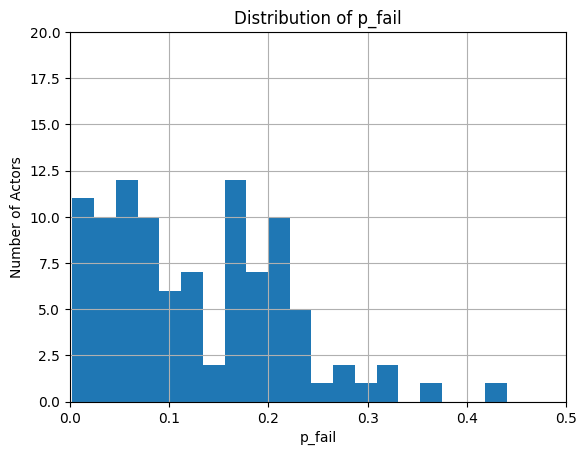

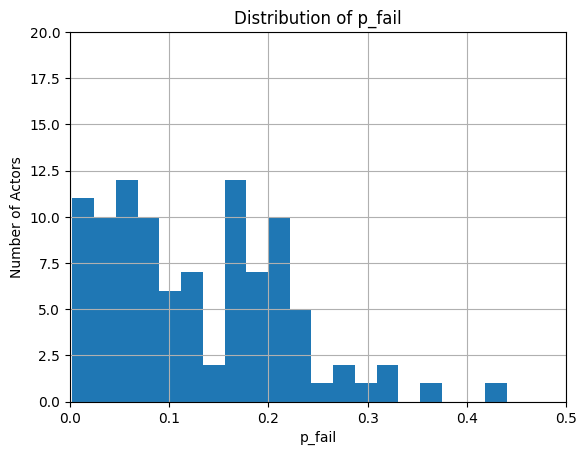

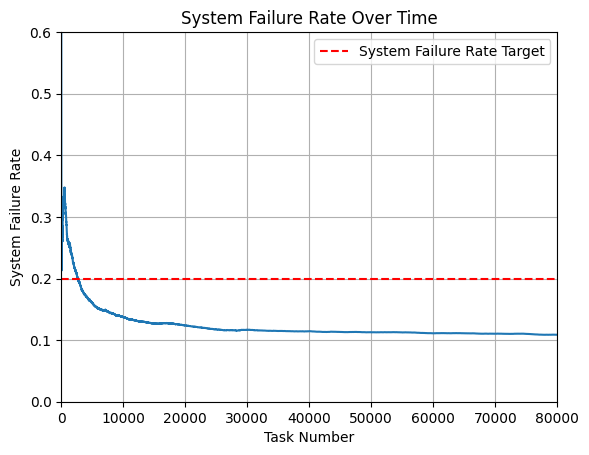

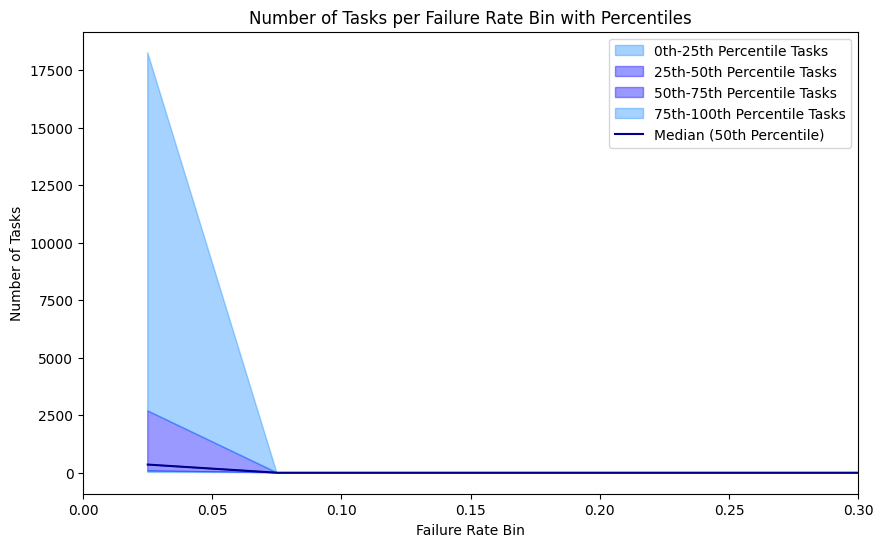

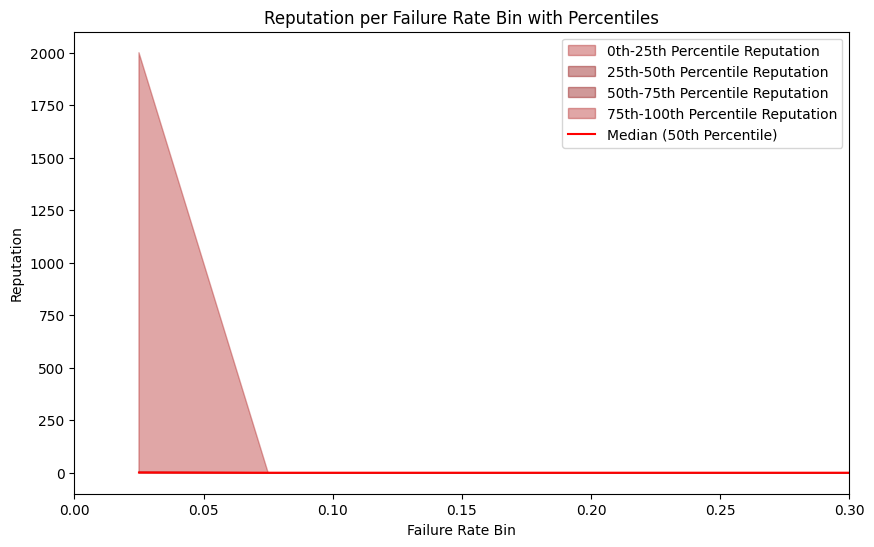

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 71302
Total failed tasks: 8698
Total number of actors: 100
Final number of actors: 100


In [233]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()
plt.show()

# NUMBER OF TASKS PER FAILURE RATE BIN
# Create the bins based on BIN_SIZE
failure_bins = np.arange(0, 1, BIN_SIZE)  # Create bins from 0 to 1 with step of BIN_SIZE

# Initialize a dictionary to store tasks per bin
tasks_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group tasks by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        tasks_per_bin[bin_index].append(actor.nb_tasks)

# Prepare percentile data for plotting
bin_centers = [failure_bins[i] + BIN_SIZE / 2 for i in range(len(failure_bins) - 1)]
tasks_percentiles = [np.percentile(tasks_per_bin[i], [0, 25, 50, 75, 100]) if tasks_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
tasks_0th = np.array([x[0] for x in tasks_percentiles])
tasks_25th = np.array([x[1] for x in tasks_percentiles])
tasks_50th = np.array([x[2] for x in tasks_percentiles])
tasks_75th = np.array([x[3] for x in tasks_percentiles])
tasks_100th = np.array([x[4] for x in tasks_percentiles])

# Plot the number of tasks with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, tasks_0th, tasks_25th, color='dodgerblue', alpha=0.4, label='0th-25th Percentile Tasks')
plt.fill_between(bin_centers, tasks_25th, tasks_50th, color='blue', alpha=0.4, label='25th-50th Percentile Tasks')
plt.fill_between(bin_centers, tasks_50th, tasks_75th, color='blue', alpha=0.4, label='50th-75th Percentile Tasks')
plt.fill_between(bin_centers, tasks_75th, tasks_100th, color='dodgerblue', alpha=0.4, label='75th-100th Percentile Tasks')
plt.plot(bin_centers, tasks_50th, color='darkblue', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# REPUTATION PER FAILURE RATE BIN
# Initialize a dictionary to store reputations per bin
reputation_per_bin = {i: [] for i in range(len(failure_bins) - 1)}

# Group reputations by failure rate bins
for actor in actors:
    bin_index = np.digitize(actor.failure_rate, failure_bins) - 1
    if 0 <= bin_index < len(failure_bins) - 1:
        reputation_per_bin[bin_index].append(actor.reputation)

# Prepare percentile data for plotting
reputation_percentiles = [np.percentile(reputation_per_bin[i], [0, 25, 50, 75, 100]) if reputation_per_bin[i] else [0, 0, 0, 0, 0] for i in range(len(failure_bins) - 1)]

# Convert to arrays for easier manipulation
reputation_0th = np.array([x[0] for x in reputation_percentiles])
reputation_25th = np.array([x[1] for x in reputation_percentiles])
reputation_50th = np.array([x[2] for x in reputation_percentiles])
reputation_75th = np.array([x[3] for x in reputation_percentiles])
reputation_100th = np.array([x[4] for x in reputation_percentiles])

# Plot reputation with percentile bands
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, reputation_0th, reputation_25th, color='firebrick', alpha=0.4, label='0th-25th Percentile Reputation')
plt.fill_between(bin_centers, reputation_25th, reputation_50th, color='darkred', alpha=0.4, label='25th-50th Percentile Reputation')
plt.fill_between(bin_centers, reputation_50th, reputation_75th, color='darkred', alpha=0.4, label='50th-75th Percentile Reputation')
plt.fill_between(bin_centers, reputation_75th, reputation_100th, color='firebrick', alpha=0.4, label='75th-100th Percentile Reputation')
plt.plot(bin_centers, reputation_50th, color='red', label='Median (50th Percentile)')
plt.xlabel('Failure Rate Bin')
plt.ylabel('Reputation')
plt.title('Reputation per Failure Rate Bin with Percentiles')
plt.xticks(ticks=failure_bins)
plt.legend()
plt.xlim(0, 0.3)  # Set x-axis limits
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')